# Influence of Southern Hemispheres Winds on Northern Hemisphere Ocean via Kelvin and Rossby Waves

In [6]:
import cosima_cookbook as cc
import seaborn as sns

In [2]:
import distributed
client = distributed.Client()
client

Client Scheduler: tcp://127.0.0.1:46023 Dashboard: http://127.0.0.1:8787,Cluster Workers: 8 Cores: 8 Memory: 20.20 GB


In [7]:
client

Client Scheduler: tcp://127.0.0.1:46023 Dashboard: http://127.0.0.1:8787,Cluster Workers: 8 Cores: 8 Memory: 20.20 GB


In [8]:
%matplotlib inline

import xarray as xr
import dask.array as da
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4
import tqdm

In [9]:
from ipywidgets import widgets, fixed, interact, interactive

In [10]:
import dask.bag
import dask.dataframe as dd
import distributed
from distributed.diagnostics.progressbar import progress

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')

## Kelvin Waves

In general, for continuous stratification, we would need to solve an eigenvalue problem to estimate the speed of the normal modes.  

Such waves such decay in a tranverse directory at a scale given by the internal deformation radius.

Waves propagate only in one direction which eddies and barotropic current is generally in the opposite direction.

### Vertical density profile

In [5]:
pot_rho_0 = cc.get_nc_variable('KDS75', 'ocean.nc', 'pot_rho_0', n=9,
                         time_units = 'days since 2000-01-01')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt


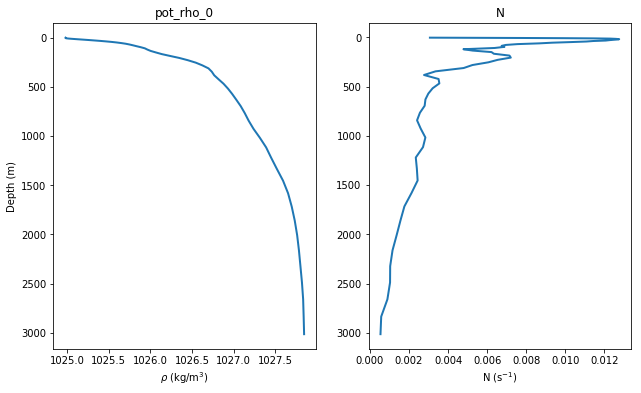

In [76]:
plt.figure(figsize=(16,6))
var = pot_rho_0.sel(xt_ocean=slice(-50, -48),
              yt_ocean=slice(-32, -30+1))\
                .mean('xt_ocean').mean('yt_ocean').mean('time')

plt.subplot(131)
plt.plot(var, var.st_ocean, linewidth=2,)
plt.gca().invert_yaxis()
plt.title('pot_rho_0')
plt.ylabel('Depth (m)')
plt.xlabel('$\\rho$ (kg/m$^3$)')

plt.subplot(132)
g = 9.8
ρ0 = 1025
N = np.sqrt(g/ρ0 * var.diff('st_ocean')/var.st_ocean.diff('st_ocean'))
plt.plot(N, N.st_ocean, linewidth=2)
plt.gca().invert_yaxis()
plt.title('N')
plt.xlabel('N (s$^{-1}$)')


In [25]:
var.load()
display(var)
H = var.st_ocean.max()
print('Max depth', H)

<xarray.DataArray 'pot_rho_0' (st_ocean: 75)>
array([ 1024.980641,  1024.979368,  1024.979309,  1024.980679,  1024.985314,
        1024.996124,  1025.015424,  1025.043775,  1025.080025,  1025.121979,
        1025.169663,  1025.222007,  1025.277713,  1025.337118,  1025.400749,
        1025.463836,  1025.529378,  1025.591921,  1025.648696,  1025.7028  ,
        1025.748171,  1025.790664,  1025.834773,  1025.885598,  1025.933885,
        1025.963868,  1026.003773,  1026.065593,  1026.136498,  1026.235796,
        1026.34752 ,  1026.448935,  1026.54518 ,  1026.624637,  1026.697878,
        1026.73741 ,  1026.767001,  1026.819493,  1026.878513,  1026.931442,
        1026.981788,  1027.031632,  1027.084626,  1027.132923,  1027.179664,
        1027.23858 ,  1027.314794,  1027.390153,  1027.450648,  1027.518562,
        1027.593404,  1027.653711,  1027.697535,  1027.733763,  1027.762789,
        1027.78437 ,  1027.802339,  1027.82066 ,  1027.834845,  1027.840887,
        1027.846293,          

Max depth <xarray.DataArray 'st_ocean' ()>
array(5709.442914225761)


In [29]:
ρ = var.dropna('st_ocean')
display(ρ)
H = ρ.st_ocean.max()
print('Max depth', H)

<xarray.DataArray 'pot_rho_0' (st_ocean: 61)>
array([ 1024.980641,  1024.979368,  1024.979309,  1024.980679,  1024.985314,
        1024.996124,  1025.015424,  1025.043775,  1025.080025,  1025.121979,
        1025.169663,  1025.222007,  1025.277713,  1025.337118,  1025.400749,
        1025.463836,  1025.529378,  1025.591921,  1025.648696,  1025.7028  ,
        1025.748171,  1025.790664,  1025.834773,  1025.885598,  1025.933885,
        1025.963868,  1026.003773,  1026.065593,  1026.136498,  1026.235796,
        1026.34752 ,  1026.448935,  1026.54518 ,  1026.624637,  1026.697878,
        1026.73741 ,  1026.767001,  1026.819493,  1026.878513,  1026.931442,
        1026.981788,  1027.031632,  1027.084626,  1027.132923,  1027.179664,
        1027.23858 ,  1027.314794,  1027.390153,  1027.450648,  1027.518562,
        1027.593404,  1027.653711,  1027.697535,  1027.733763,  1027.762789,
        1027.78437 ,  1027.802339,  1027.82066 ,  1027.834845,  1027.840887,
        1027.846293])
Coordina

Max depth <xarray.DataArray 'st_ocean' ()>
array(3012.6313812062995)


### Estimation of wave speed (assuming two-layer model)

Using a two-layer model, the speed of an internal Kelvin wave is given by

$$ c = \sqrt{ \frac{\rho_2 - \rho_1}{\rho_2} \frac{g h_1 h_2}{h_1 + h_2} } $$

In [88]:
results = []
for k in range(1, 50):
    ρ1 = ρ.isel(st_ocean=slice(None,k))
    h1 = ρ1.st_ocean.max() - ρ1.st_ocean.min()
    ρ1 = ρ1.mean('st_ocean')
    
    ρ2 = ρ.isel(st_ocean=slice(k, None))
    h2 = ρ2.st_ocean.max() - ρ2.st_ocean.min()
    ρ2 = ρ2.mean('st_ocean').values
    
    c = np.sqrt( (ρ2 - ρ1)/ρ2 * g*h1*h2/(h1+h2))
    results.append( [k, c, ρ1, ρ2, h1, h2] )
    
k, c, ρ1, ρ2, h1, h2 = np.asarray(results).T

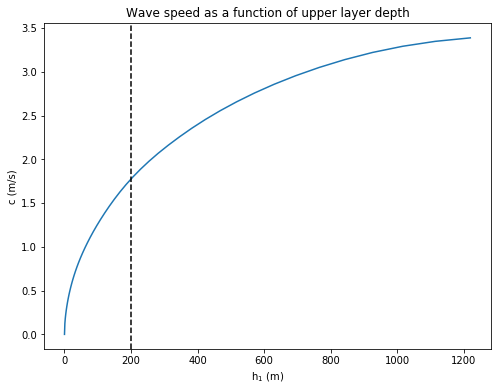

In [89]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(h1, c)
plt.ylabel('c (m/s)')
plt.xlabel('h$_1$ (m)')
plt.title('Wave speed as a function of upper layer depth')

plt.axvline(200, linestyle='--', color='k')

So, roughly speaking, we are looking for internal wave modes that travelling around 1.5 m/s assume a upper layer depth of 200 m.

In five days, how far would such a wave travel?

In [92]:
c = 1.5 # m/s
days = 5
d = c * (days * 24*3600)
d

648000.0

## Bottom topography

In [11]:
ht = cc.get_nc_variable('KDS75', 'ocean_grid', 'ht', n=1).mean('time')

<xarray.DataArray 'ht' (yt_ocean: 2700, xt_ocean: 3600)>
dask.array<mean_agg-aggregate, shape=(2700, 3600), dtype=float64, chunksize=(675, 900)>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 -279.4 ...
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 -80.98 -80.94 -80.9 ...

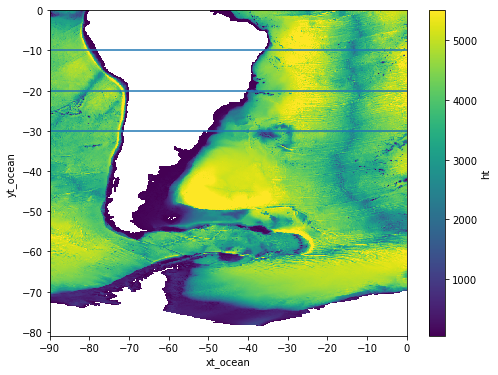

In [12]:
plt.figure(figsize=(8,6))

var = ht.sel(xt_ocean=slice(-90, 0), yt_ocean=slice(-90, 0))

var.plot()

for lat in [-10, -20, -30]:
    plt.axhline(lat)


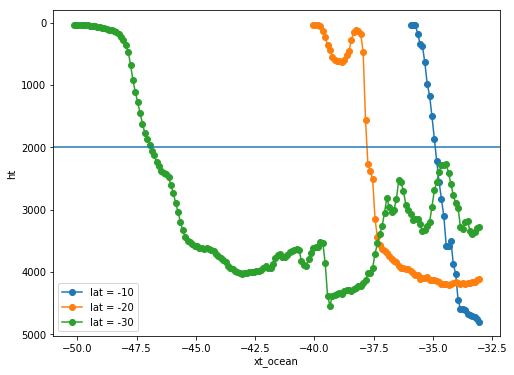

In [97]:
plt.figure(figsize=(8,6))
for lat in [-10, -20, -30]:
    var = ht.sel(xt_ocean=slice(-60, -33)).sel(yt_ocean=slice(lat, lat+1)).mean('yt_ocean')
    
    var.plot(marker='o', label = 'lat = {}'.format(lat))

plt.gca().invert_yaxis()

plt.legend()

plt.axhline(2000)

### Estimate 2000 m depth contour

We want the 2000m depth contour along the western boundary of the Atlantic ocean.

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


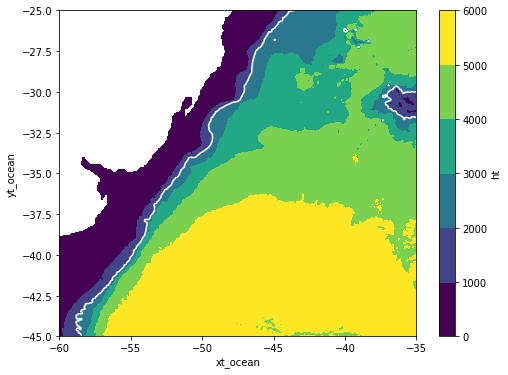

In [15]:
plt.figure(figsize=(8,6))
ht.sel(xt_ocean=slice(-70, -30), yt_ocean=slice(-45, -25)).plot.contourf()
c = ht.sel(xt_ocean=slice(-70, -30), yt_ocean=slice(-45, -25)).plot.contour(levels=[2000], 
                                                                            colors='w')
plt.ylim(-45, -25)
plt.xlim(-60, -35)
plt.show()


In [16]:
contour = np.vstack([p.vertices for p in c.collections[0].get_paths()])

(-60, -35)

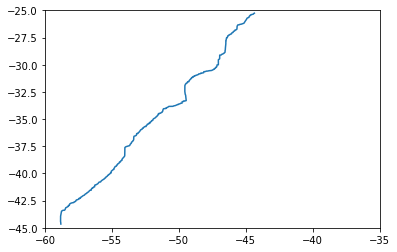

In [100]:
df2 = pd.DataFrame(contour, columns=['x', 'y']).groupby(['y']).min().rolling(15, center=True).min().drop_duplicates()

df = df2.reset_index().dropna()

plt.plot(df.x, df.y)
plt.ylim(-45, -25)
plt.xlim(-60, -35)

In [17]:
dy = 0.05
dx = 0.05
hts = []
for y, x in df.values:
    s = ht.sel(xt_ocean=slice(x-dx, x+dx), 
               yt_ocean=slice(y-dy, y+dy))
    s = s.isel(xt_ocean = 0, yt_ocean=0)
    hts.append(s)

s = xr.concat(hts, dim='s')

NameError: name 'df' is not defined

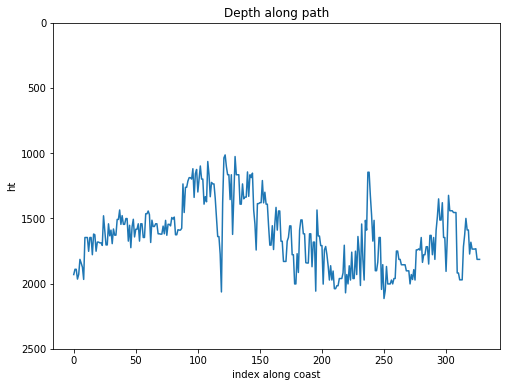

In [102]:
plt.figure(figsize=(8,6))
s.plot()

plt.ylim(0, 2500)
plt.gca().invert_yaxis()
plt.xlabel('index along coast')
plt.title('Depth along path')

In [103]:
def op(variable):
    dy = 0.05
    dx = 0.05
    pot_rhos = []
    for y,x in df.values:
        pot_rho = variable.sel(xt_ocean=slice(x-dx, x+dx), 
                               yt_ocean=slice(y-dy, y+dy))
        pot_rho = pot_rho.isel(xt_ocean = 0, yt_ocean=0)
        pot_rhos.append(pot_rho)

    pot_rho = xr.concat(pot_rhos, dim='s')
    return(pot_rho)

In [104]:
pot_rho_2 = cc.get_nc_variable('KDS75', 'ocean__', 'pot_rho_2', n=10, 
                               time_units='days since 2000-01-01', op=op)

In [105]:
pot_rho_2

<xarray.DataArray 'pot_rho_2' (s: 328, time: 10, st_ocean: 75)>
dask.array<concatenate, shape=(328, 10, 75), dtype=float64, chunksize=(1, 1, 7)>
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 4.332 5.869 7.569 9.447 ...
  * time      (time) datetime64[ns] 2098-10-18T12:00:00 2098-10-23T12:00:00 ...
    xt_ocean  (time, s) float64 -58.85 -58.85 -58.85 -58.85 -58.75 -58.75 ...
    yt_ocean  (time, s) float64 -44.68 -44.47 -44.47 -43.97 -43.53 -43.46 ...
    geolon_t  (time, s) float64 -58.85 -58.85 -58.85 -58.85 -58.75 -58.75 ...
    geolat_t  (time, s) float64 -44.68 -44.47 -44.47 -43.97 -43.53 -43.46 ...
Dimensions without coordinates: s
Attributes:
    long_name:      potential density referenced to 2000 dbar
    units:          kg/m^3
    valid_range:    [ -1.00000000e+01   1.00000000e+05]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

(2500, -0.028446191828301437)

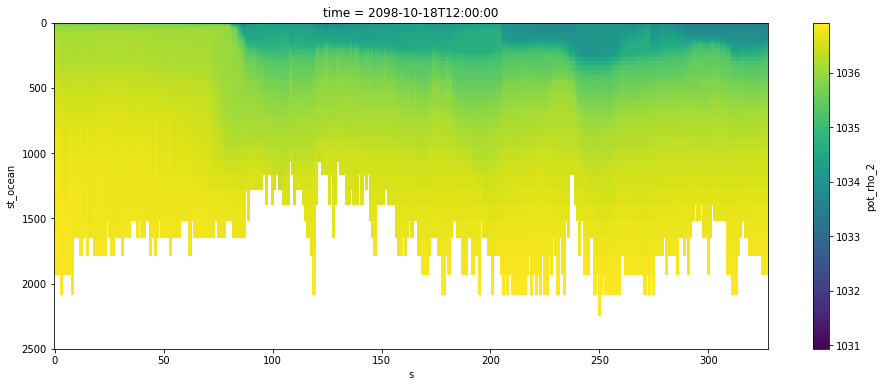

In [16]:
fig, ax = plt.subplots(figsize=(16,6))
pot_rho_2.isel(time=0).plot.pcolormesh('s', 'st_ocean', yincrease=False, ax=ax)
ax.set_ylim(ymin=2500)

In [17]:
fig, ax = plt.subplots(figsize=(14,6))

ims = []
for i in tqdm.tqdm_notebook(range(10)):
    p = pot_rho_2.isel(time=i)
    im = p.plot.pcolormesh('s', yincrease=False, add_colorbar=False, ax=ax)
    
    ts = pd.to_datetime(str(pot_rho_2.time[i].values)).strftime('%Y-%m-%d') 
    t = ax.text(50, 2200, ts, color='black', size=18)
    ims.append([im, t])

ax.set_ylim(ymin=2500)

ani = animation.ArtistAnimation(fig, ims, interval=1000, 
                                blit=True,
                                repeat_delay=1000)
plt.close()

In [22]:
ani = animation.ArtistAnimation(fig, ims, interval=1000, 
                                blit=True,
                                repeat_delay=1000)

In [23]:
ani

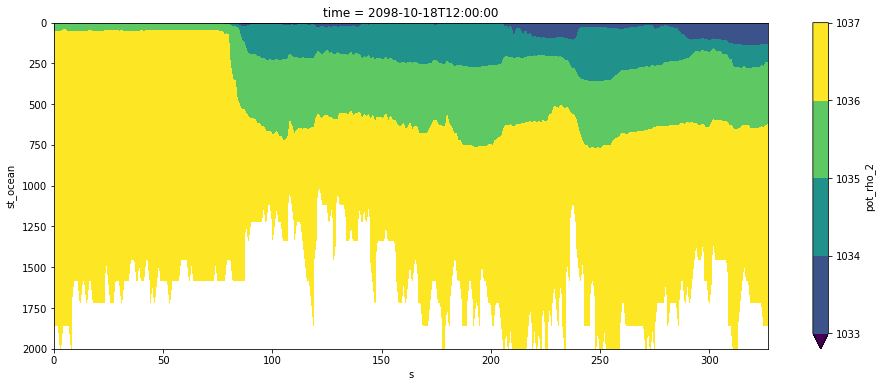

In [46]:
fig, ax = plt.subplots(figsize=(16,6))
pot_rho_2.isel(time=0).plot.contourf('s', yincrease=False, ax=ax,
                                    levels = [1033, 1034, 1035, 1036, 1037])
ax.set_ylim(ymin=2000)
plt.show()

(2000, 0.54128076539161007)

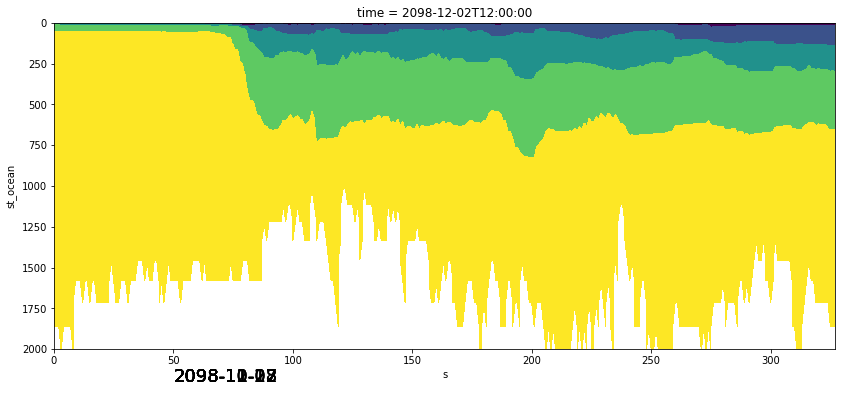

In [16]:
fig, ax = plt.subplots(figsize=(14,6))

ims = []
for i in tqdm.tqdm_notebook(range(10)):
    p = pot_rho_2.isel(time=i)
    im = p.plot.contourf('s', yincrease=False, add_colorbar=False, ax=ax,
                        levels = [1033, 1034, 1035, 1036, 1037])
    
    ts = pd.to_datetime(str(pot_rho_2.time[i].values)).strftime('%Y-%m-%d') 
    t = ax.text(50, 2200, ts, color='black', size=18)
    ims.append([im, t])

ax.set_ylim(ymin=2000)

In [17]:
# see https://github.com/matplotlib/matplotlib/issues/6139 for discussion of animating contour plots

import types
for im, t in ims:
    print(im)
    
    #################################################################
    ## Bug fix for Quad Contour set not having attribute 'set_visible'
    def setvisible(self,vis):
        for c in self.collections: c.set_visible(vis)
    def setanimated(self,ani):
        for c in self.collections: c.set_animated(ani)
    def getfigure(self):
        return self.figure       
    im.set_visible = types.MethodType(setvisible,im)
    im.set_animated = types.MethodType(setanimated,im)
    im.get_figure = types.MethodType(getfigure,im)
    im.axes = ax
    im.figure=fig
    ####################################################################

In [23]:
ani = animation.ArtistAnimation(fig, ims, interval=1000, 
                                blit=True,
                                repeat_delay=3000)

In [24]:
display(ani)

In [132]:
pot_rho_0 = cc.get_nc_variable('KDS75', 'ocean__', 'pot_rho_0', n=10, 
                               time_units='days since 2000-01-01', op=op)

In [114]:
from joblib import Memory
memory = Memory(cachedir='/g/data1/v45/jm0634/demo', verbose=0)

In [133]:
@memory.cache
def get_pot_rho(i):
    "get potential_rho at a time index i"
    
    p = pot_rho_0.isel(time=i).load()
    return p

In [134]:
%%time
p = get_pot_rho(0)

CPU times: user 8.24 s, sys: 324 ms, total: 8.56 s
Wall time: 8.56 s


In [161]:
def plot_contours(i):
    print('loading...', end='')
    p = get_pot_rho(i)
    fig, ax = plt.subplots(figsize=(12,6))
    p.plot.contourf('s', yincrease=False, add_colorbar=True, ax=ax,
               levels = np.arange(1024, 1028, 0.5), 
               )
    ax.set_ylim(ymin=2000)
    print('done')
    plt.show()
    
interactive(plot_contours, i=range(10))

### Potential Density at  300 m depth

In [ ]:
pot_rho_2 = cc.get_nc_variable('KDS75', 'ocean__', 'pot_rho_2', 
                            time_units='days since 2000', 
                               op = lambda x: x.sel(st_ocean=slice(300,330), 
                                                    yt_ocean=slice(-60,-10), 
                                                    xt_ocean=slice(-70,-20)),
                               n=72)
pot_rho_2

In [101]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()

ims = []
for i in tqdm.tqdm_notebook(range(72)):
    p = pot_rho_2.isel(time=i).squeeze()
    im = p.plot.pcolormesh(add_colorbar=False, ax=ax)
    
    ts = pd.to_datetime(str(pot_rho_2.time[i].values)).strftime('%y/%m/%d') 
    t = ax.text(-65, -20, ts, color='black', size=18)
    ims.append([im, t])

ax.set_title('pot_rho_2 at st_ocean={:.0f} m'.format(pot_rho_2.st_ocean.values[0]))
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.close(fig)

In [102]:
ani

In [16]:
ani